In [1]:
# data manipulation
import pandas as pd
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
from sklearn.preprocessing import Normalizer, StandardScaler

# Machine Learning
from sklearn.cluster import KMeans

# Cluster evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Cluster visualization
import plotly.express as px
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv("Credit Card_Clustering.csv")

In [3]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

# Data Cleaning

In [5]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

<AxesSubplot:>

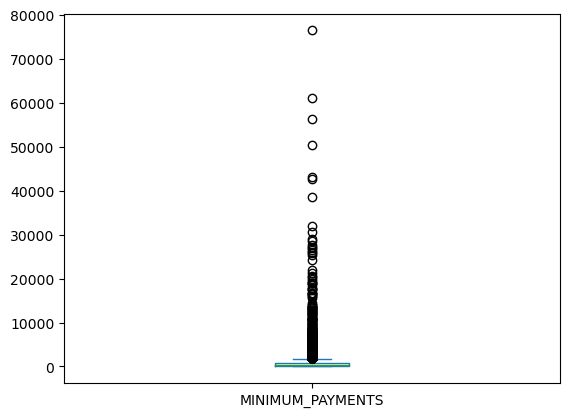

In [6]:
df["MINIMUM_PAYMENTS"].plot(kind="box")

In [7]:
#Since there is huge number of outliers its better to fil the missing values with median
df.dropna(subset=["CREDIT_LIMIT"], inplace=True)
df["MINIMUM_PAYMENTS"] =  df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].median())

In [8]:
#Drop the Customer ID
df.drop("CUST_ID",axis=1,inplace=True)

# Data Visualization

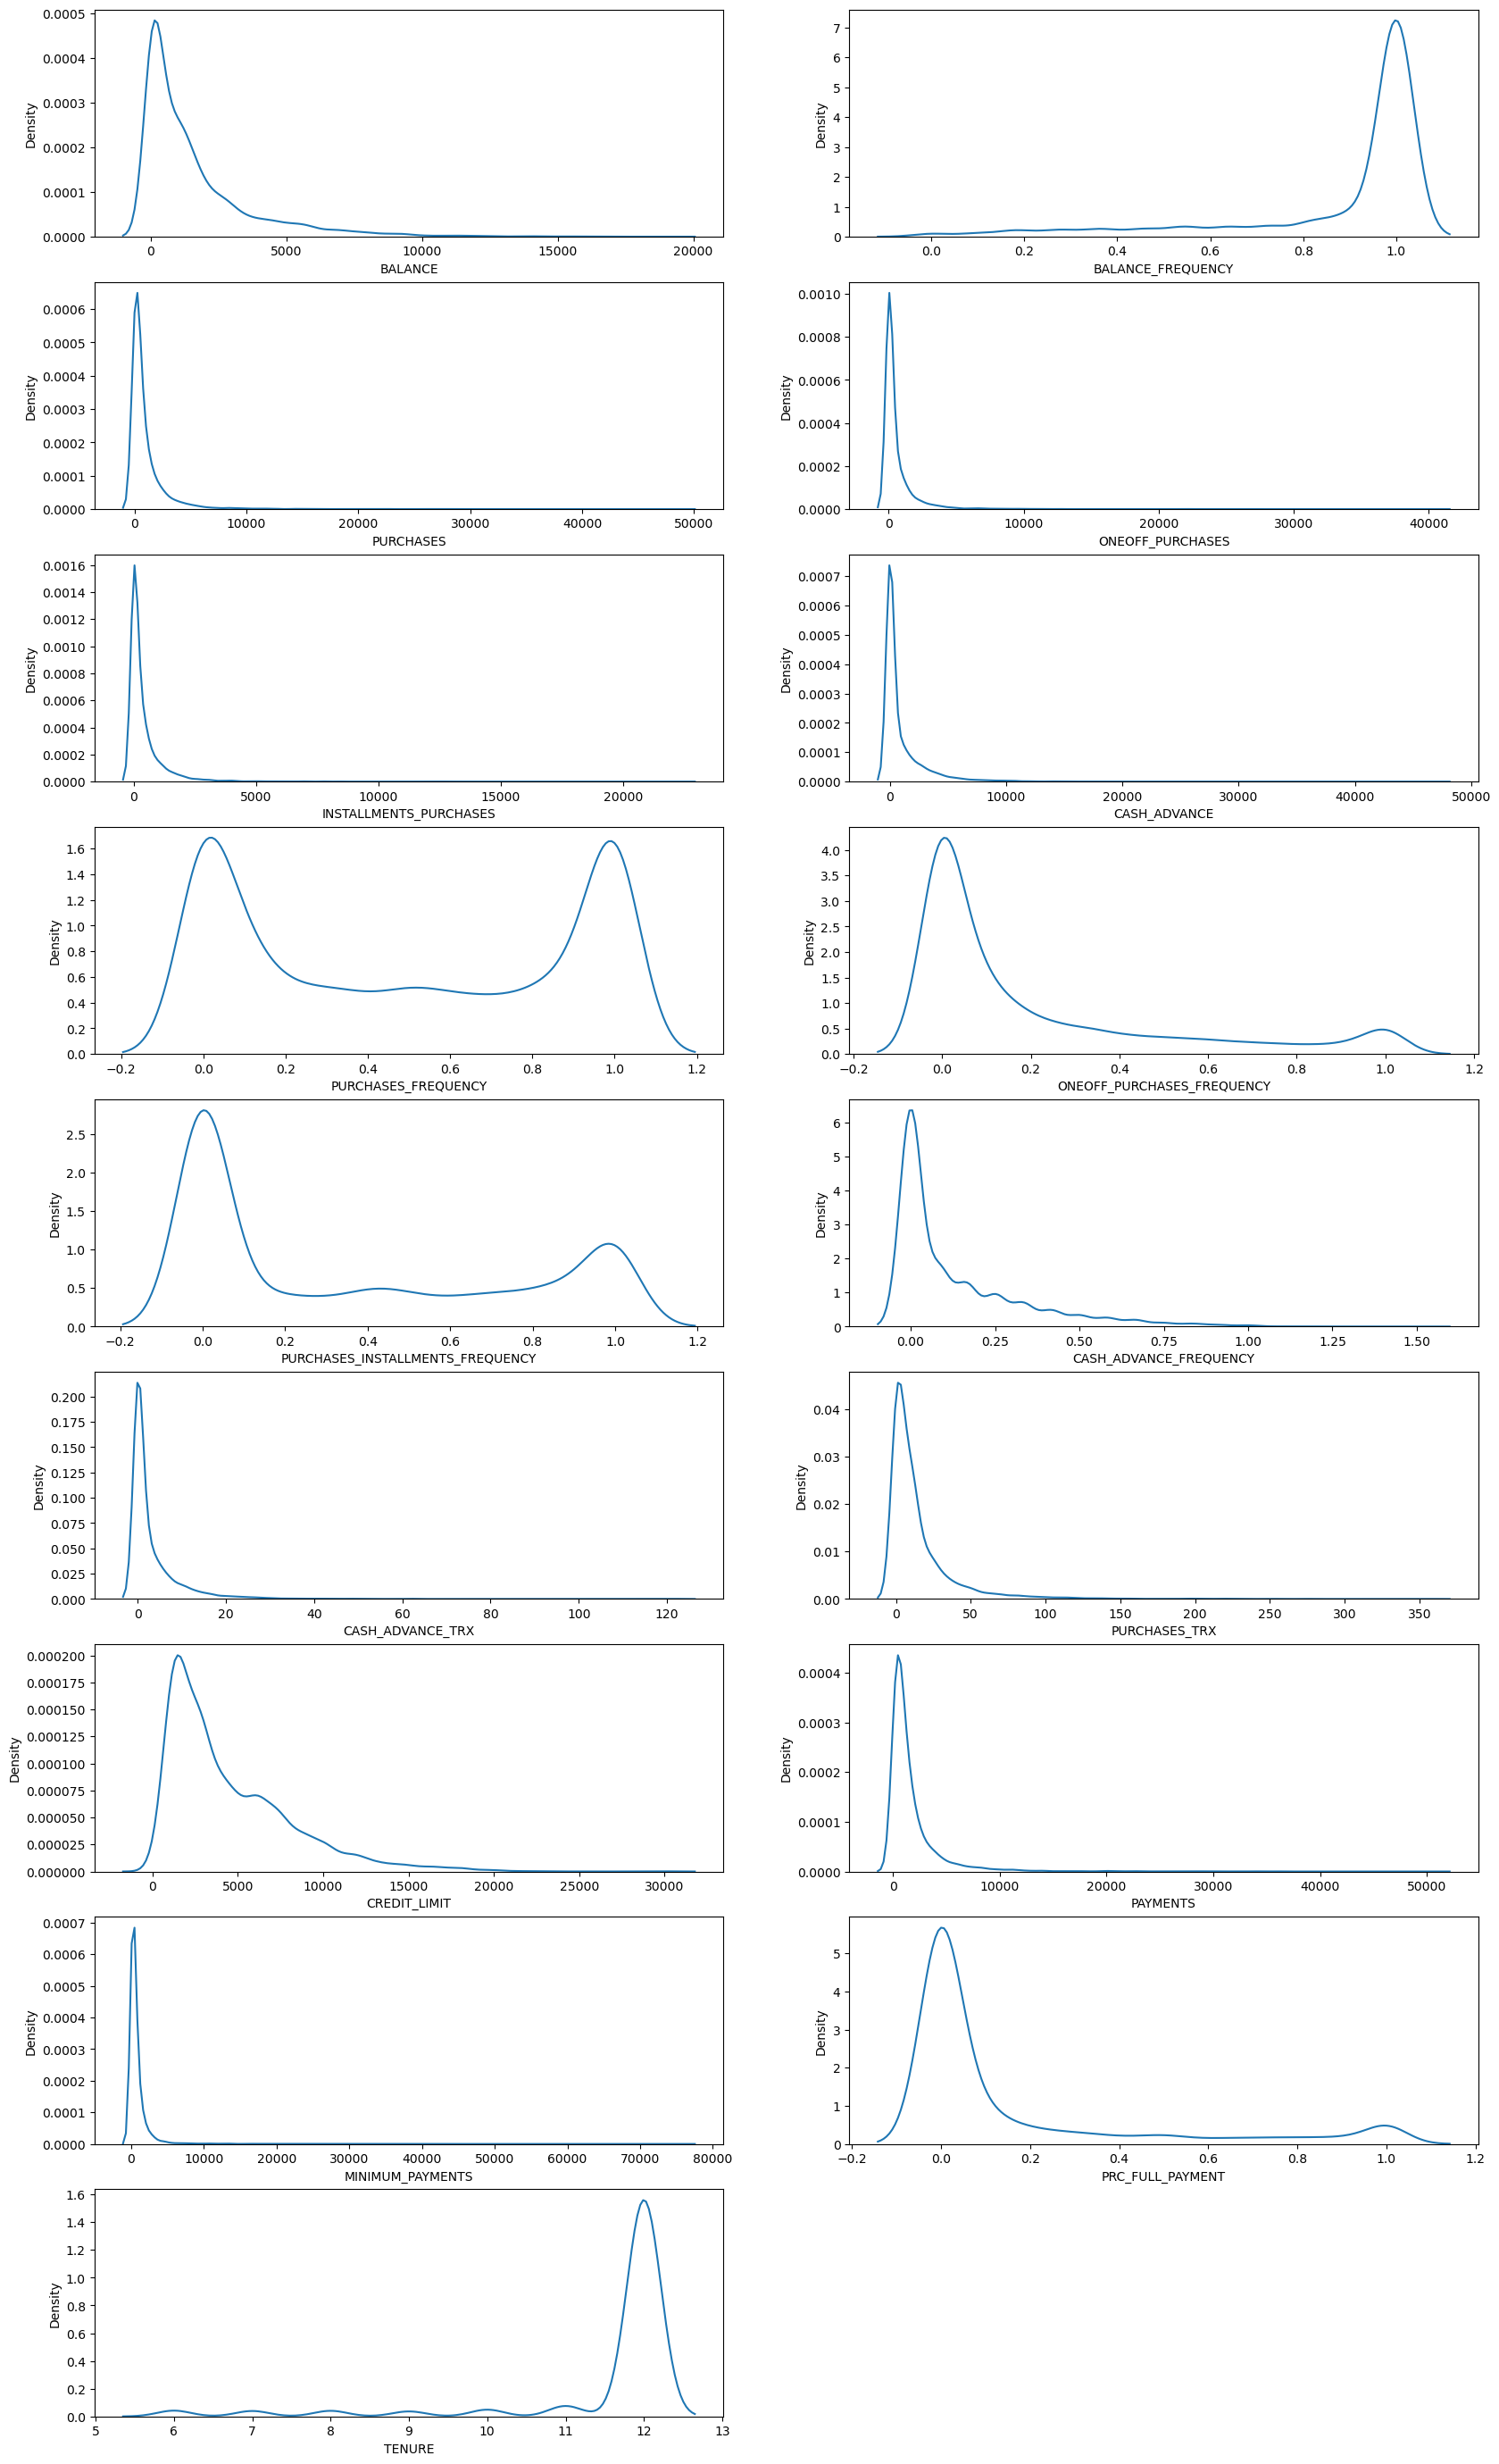

In [9]:
plt.figure(figsize=(20,35))
for i,col in enumerate(df.columns):
    if df[col].dtype != object:
        ax = plt.subplot(9,2,i+1)
        sns.kdeplot(df[col],ax=ax)
        plt.xlabel(col)
plt.show()

From the above plots its clearly visible that the data is highly skewed and it is expected from the customers as some
of them make purchases in a huge volume. As our objective is customer segmentation, we need handle these outliers or skewness
as much as possible to get proper clusters.

In [10]:
cols = ['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 
        'ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_TRX', 
        'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']

In [11]:
cols

['BALANCE',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT']

Taking the natural logarithm of a variable x is a common transformation used in data analysis to reduce the effect of outliers and to make the data more symmetrically distributed

In [12]:
for col in cols:
    df[col] = np.log(1+df[col])

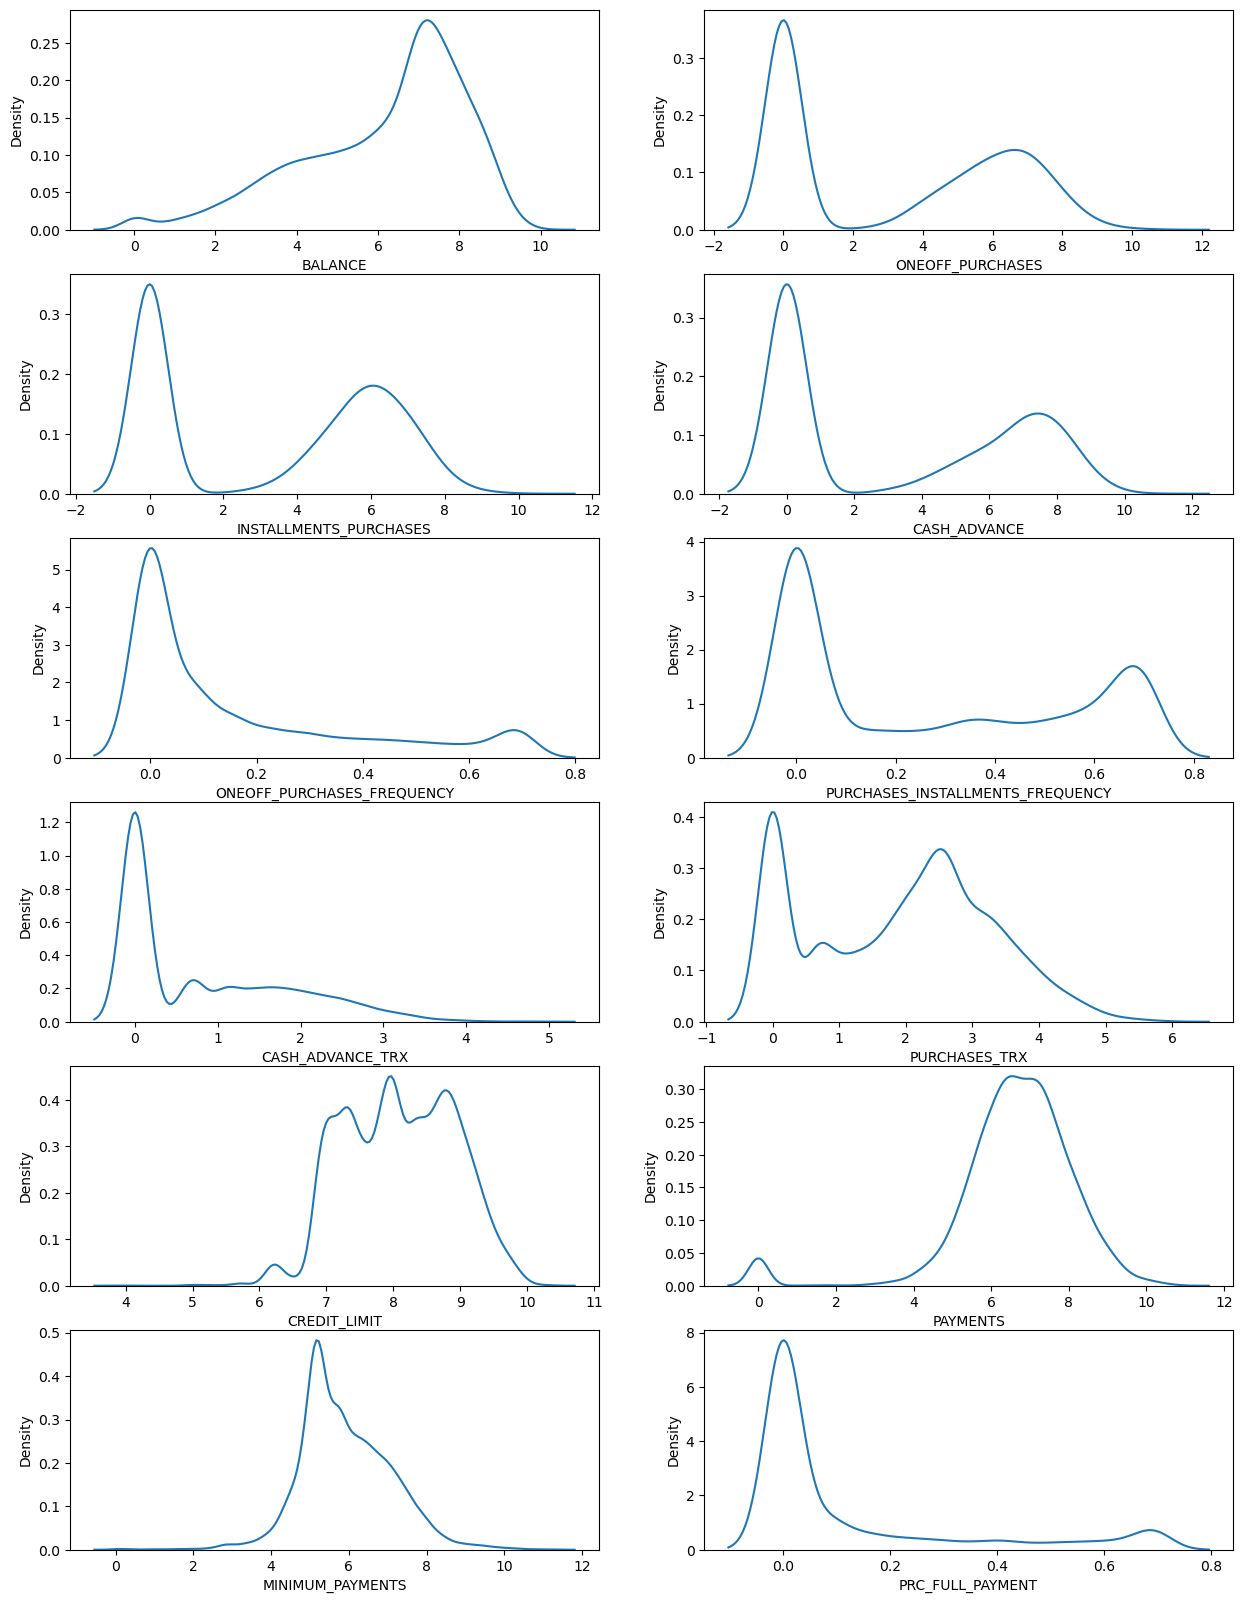

In [13]:
plt.figure(figsize=(15,20))
for i,col in enumerate(cols):
    ax=plt.subplot(6,2,i+1)
    sns.kdeplot(df[col],ax=ax)
plt.show()

It looks much better than the previous

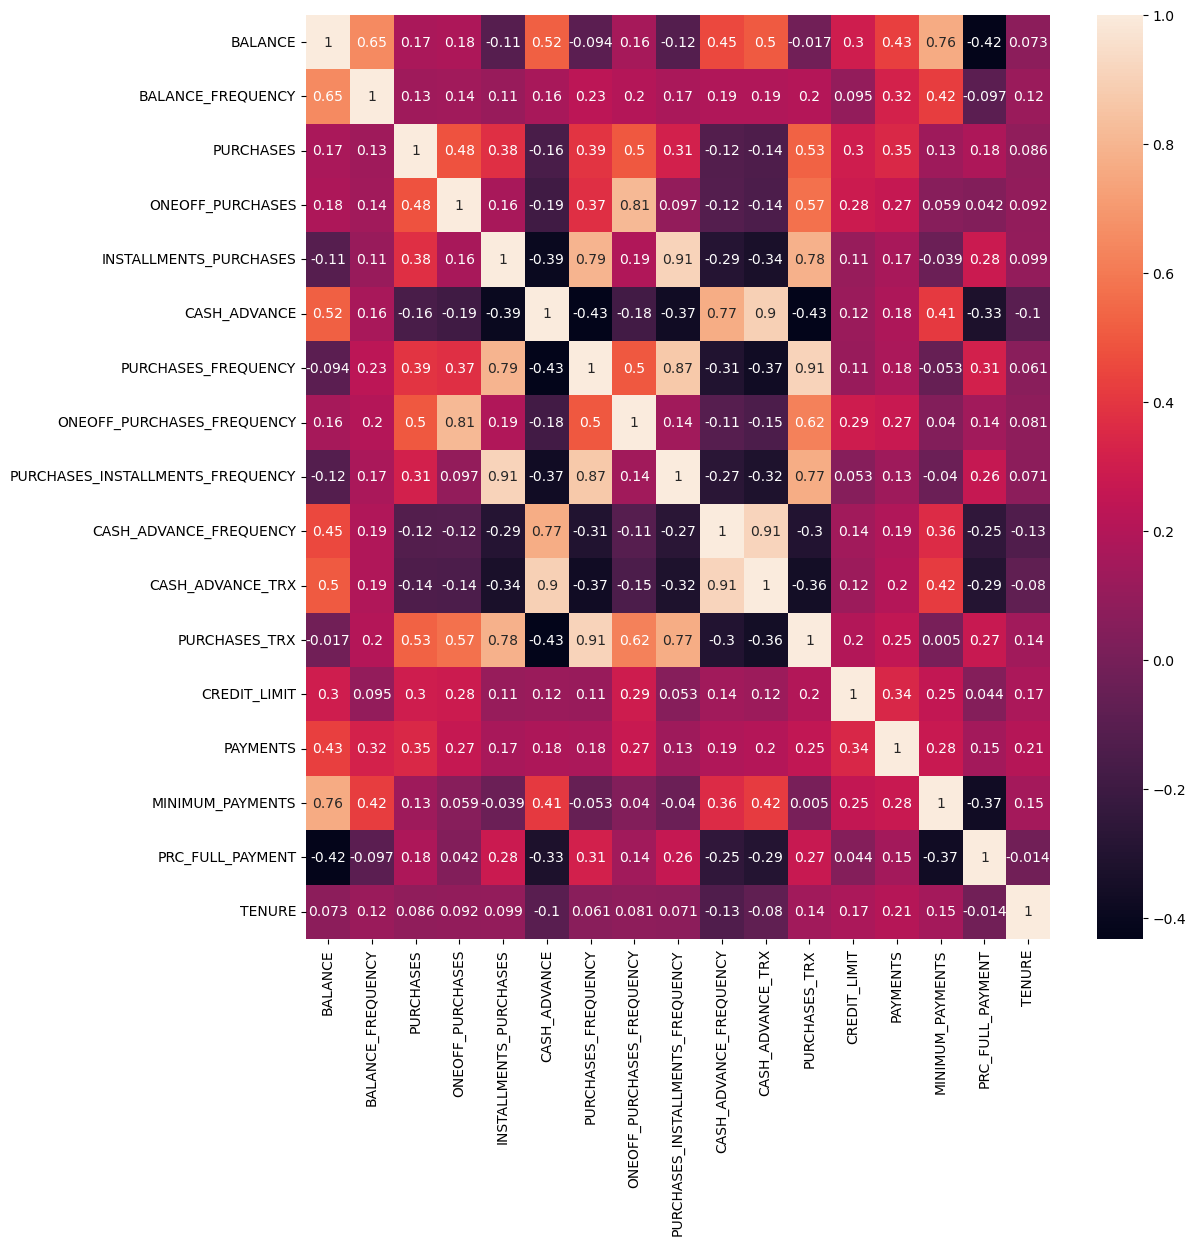

In [14]:
#Correlation
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [15]:
#Dimensionality Reduction - Principal Component Analysis
#We will select the number of components such that our data in the lower dimensions explains 95% of variance of our original data.
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
X_red = pca.fit_transform(df)

In [16]:
X_red

array([[ -907.91841659],
       [-1003.32175301],
       [ -230.14452124],
       ...,
       [ -858.91859726],
       [-1003.32321803],
       [   89.93281795]])

# Model Training

In [17]:
from sklearn.cluster import KMeans

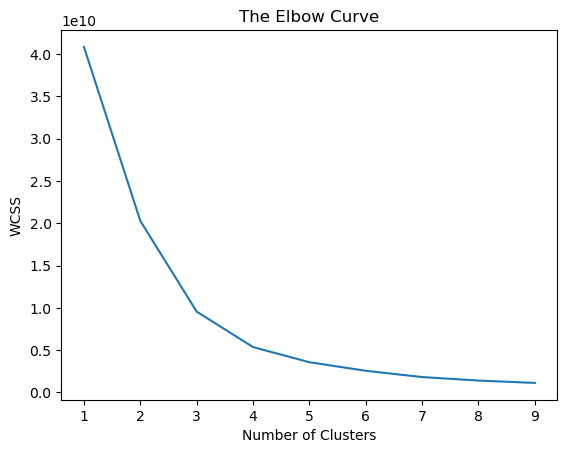

In [18]:
kmeans = [KMeans(n_clusters = i, init="k-means++",random_state=23).fit(X_red) for i in range(1,10)]
inertia = [model.inertia_ for model in kmeans]
    
plt.plot(range(1,10),inertia)
plt.title("The Elbow Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

We can either use 3 or 4 from the above curve, lets compare using silhoutte score

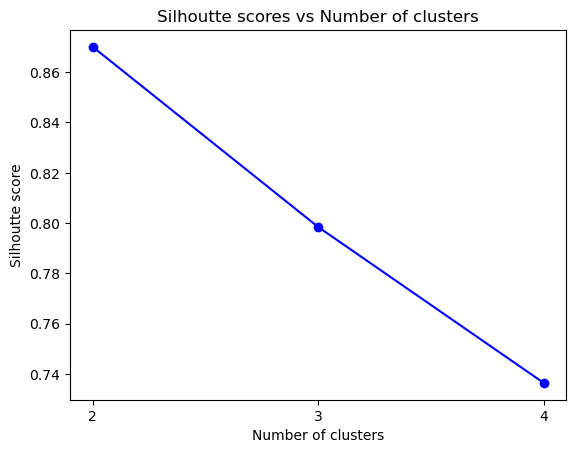

In [19]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_red,model.labels_) for model in kmeans[1:4]]
plt.plot(range(2,5), silhouette_scores, "bo-")
plt.xticks([2, 3, 4])
plt.title('Silhoutte scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

It seems 2 has a better silhouette score than the rest

# Model Evaluaion

In [20]:
kmeans = KMeans(n_clusters = 2,init = "k-means++",random_state=23)
kmeans.fit(X_red)

print("Silhouette score of the model is " + str(silhouette_score(X_red,kmeans.labels_)))

Silhouette score of the model is 0.8700455999562429


In [21]:
#Assigning labels as cluster index
df["Cluster_id"] = kmeans.labels_

In [22]:
#Inverse transforming the log transformation that we did for visualization
for col in cols:
    df[col] = np.exp(df[col])

In [23]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster_id
0,41.900749,0.818182,95.40,1.00,96.4,1.000000,0.166667,1.000000,1.083333,0.000000,1.0,3.0,1001.0,202.802084,140.509787,1.000000,12,0
1,3203.467416,0.909091,0.00,1.00,1.0,6443.945483,0.000000,1.000000,1.000000,0.250000,5.0,1.0,7001.0,4104.032597,1073.340217,1.222222,12,0
2,2496.148862,1.000000,773.17,774.17,1.0,1.000000,1.000000,2.000000,1.000000,0.000000,1.0,13.0,7501.0,623.066742,628.284787,1.000000,12,0
3,1667.670542,0.636364,1499.00,1500.00,1.0,206.788017,0.083333,1.083333,1.000000,0.083333,2.0,2.0,7501.0,1.000000,313.452292,1.000000,12,0
4,818.714335,1.000000,16.00,17.00,1.0,1.000000,0.083333,1.083333,1.000000,0.000000,1.0,2.0,1201.0,679.334763,245.791237,1.000000,12,0


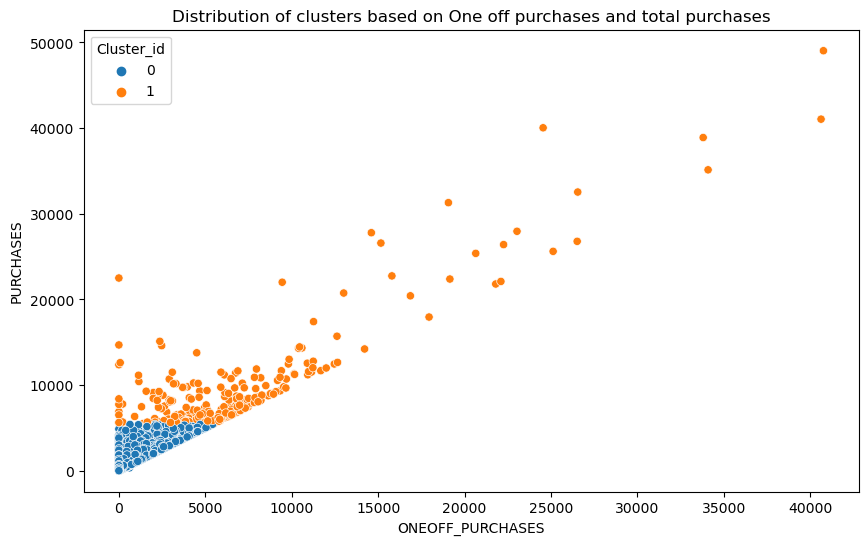

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='ONEOFF_PURCHASES', y='PURCHASES', hue='Cluster_id')
plt.title('Distribution of clusters based on One off purchases and total purchases')
plt.show()

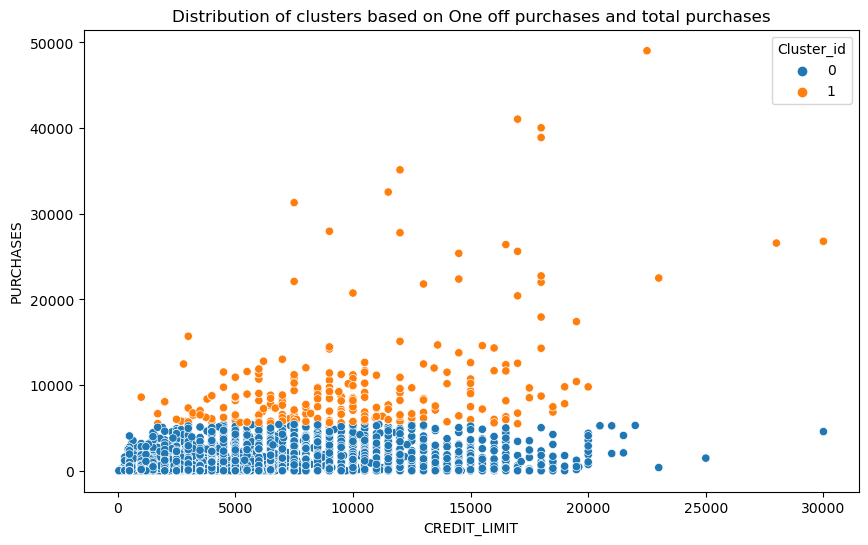

In [25]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='CREDIT_LIMIT', y='PURCHASES', hue='Cluster_id')
plt.title('Distribution of clusters based on One off purchases and total purchases')
plt.show()

# K=3

In [26]:
kmeans = KMeans(n_clusters = 3,init = "k-means++",random_state=23)
kmeans.fit(X_red)

print("Silhouette score of the model is " + str(silhouette_score(X_red,kmeans.labels_)))

Silhouette score of the model is 0.7984274911768593


In [27]:
df["Cluster_id"] = kmeans.labels_

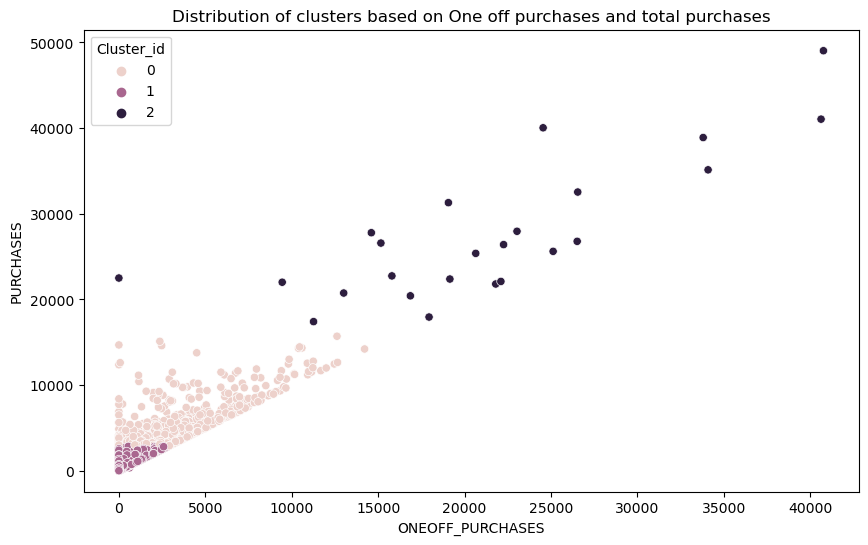

In [28]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='ONEOFF_PURCHASES', y='PURCHASES', hue='Cluster_id')
plt.title('Distribution of clusters based on One off purchases and total purchases')
plt.show()

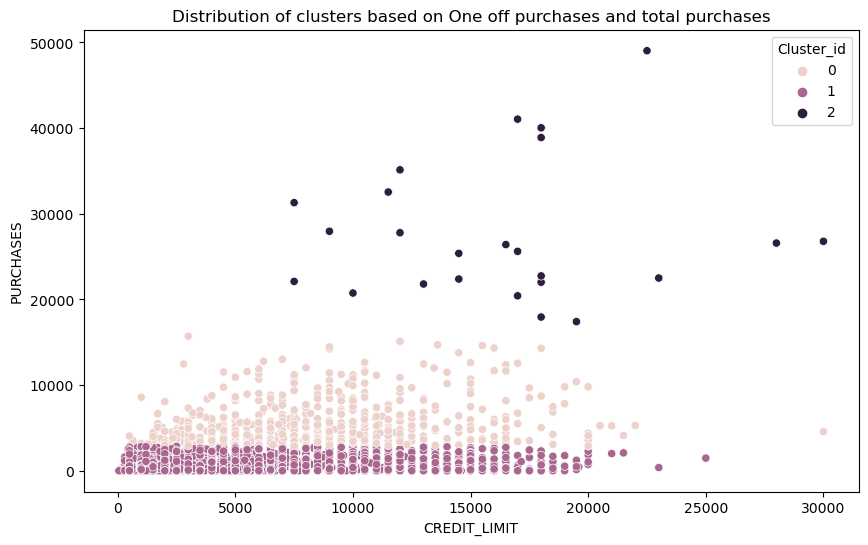

In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='CREDIT_LIMIT', y='PURCHASES', hue='Cluster_id')
plt.title('Distribution of clusters based on One off purchases and total purchases')
plt.show()

It looks k=3 seems to be a better clustering than 2 as it really segments out top half of customers having more than usual amount of usage of credit card and the customers which have very low usage